In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## IMPORT DATA

In [2]:
df = pd.read_csv('./Alcohol_Sales.csv', index_col=0, parse_dates=True)

## ANALYSE DATA

In [3]:
df.columns

Index(['S4248SM144NCEN'], dtype='object')

In [4]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
len(df)

325

In [6]:
df = df.dropna()
len(df)

325

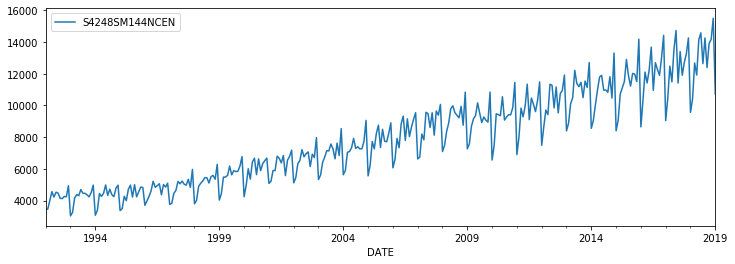

In [7]:
df.plot(figsize=(12,4))

## CLEAN AND PREPARE DATA

In [8]:
y = df['S4248SM144NCEN'].values.astype(float)
y

array([ 3459.,  3458.,  4002.,  4564.,  4221.,  4529.,  4466.,  4137.,
        4126.,  4259.,  4240.,  4936.,  3031.,  3261.,  4160.,  4377.,
        4307.,  4696.,  4458.,  4457.,  4364.,  4236.,  4500.,  4974.,
        3075.,  3377.,  4443.,  4261.,  4460.,  4985.,  4324.,  4719.,
        4374.,  4248.,  4784.,  4971.,  3370.,  3484.,  4269.,  3994.,
        4715.,  4974.,  4223.,  5000.,  4235.,  4554.,  4851.,  4826.,
        3699.,  3983.,  4262.,  4619.,  5219.,  4836.,  4941.,  5062.,
        4365.,  5012.,  4850.,  5097.,  3758.,  3825.,  4454.,  4635.,
        5210.,  5057.,  5231.,  5034.,  4970.,  5342.,  4831.,  5965.,
        3796.,  4019.,  4898.,  5090.,  5237.,  5447.,  5435.,  5107.,
        5515.,  5583.,  5346.,  6286.,  4032.,  4435.,  5479.,  5483.,
        5587.,  6176.,  5621.,  5889.,  5828.,  5849.,  6180.,  6771.,
        4243.,  4952.,  6008.,  5353.,  6435.,  6673.,  5636.,  6630.,
        5887.,  6322.,  6520.,  6678.,  5082.,  5216.,  5893.,  5894.,
      

## CREATE DATASETS

In [9]:
test_size = 12
train_set = y[:-test_size]
test_set = y[-test_size:]
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

## NORMALIZE TRAINING SET BETWEEN -1 AND 1

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [12]:
scaler.fit(train_set.reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [13]:
train_norm = scaler.transform(train_set.reshape(-1,1))

## 

In [14]:
train_norm = torch.FloatTensor(train_norm).view(-1)
train_norm.shape

torch.Size([313])

## DATALOADER

In [15]:
#AT LEAST 12 FOR EACH MONTH
window_size = 12

In [16]:
def input_data(seq, ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label)) #tuple
    return out

In [17]:
train_data = input_data(train_norm, window_size)

In [18]:
len(train_data)

301

In [19]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]), tensor([-1.]))

## MODEL (LSTM)

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size)
        
        #(HIDDEN, CELL)
        self.hidden = (torch.zeros(1,1, hidden_size), torch.zeros(1,1, hidden_size))
        
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq), -1))
        
        #Out just last item
        return pred[-1]

## CRITERION/ OPTIMIZER

In [21]:
torch.manual_seed(101)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
model

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [23]:
numel = 0
for p in model.parameters():
    numel += (p.numel())
    print(p.numel())
print(numel)

400
40000
400
400
100
1
41301


## TRAIN AND TEST

In [24]:
epochs = 100
future = 40

import time 
start_time = time.time()

for i in range(epochs):
    
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size)
        
        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch {i} Loss: {loss.item()}')
       
total_time = time.time() - start_time
print(total_time/60)

Epoch 0 Loss: 0.2531020939350128
Epoch 1 Loss: 0.37532004714012146
Epoch 2 Loss: 0.3902720808982849
Epoch 3 Loss: 0.3493470549583435
Epoch 4 Loss: 0.3308563530445099
Epoch 5 Loss: 0.3322998285293579
Epoch 6 Loss: 0.3267035484313965
Epoch 7 Loss: 0.32074129581451416
Epoch 8 Loss: 0.30653542280197144
Epoch 9 Loss: 0.2951802909374237
Epoch 10 Loss: 0.2693434953689575
Epoch 11 Loss: 0.2599852681159973
Epoch 12 Loss: 0.2466575652360916
Epoch 13 Loss: 0.2240411639213562
Epoch 14 Loss: 0.18602602183818817
Epoch 15 Loss: 0.18561261892318726
Epoch 16 Loss: 0.17209382355213165
Epoch 17 Loss: 0.25161921977996826
Epoch 18 Loss: 0.22557635605335236
Epoch 19 Loss: 0.17449666559696198
Epoch 20 Loss: 0.20236614346504211
Epoch 21 Loss: 0.2081693708896637
Epoch 22 Loss: 0.16645215451717377
Epoch 23 Loss: 0.17598912119865417
Epoch 24 Loss: 0.11980576068162918
Epoch 25 Loss: 0.09543585777282715
Epoch 26 Loss: 0.045232102274894714
Epoch 27 Loss: 0.0641445592045784
Epoch 28 Loss: 0.00464909290894866
Epoch 2

In [26]:
future = 12
preds = train_norm[-window_size:].tolist()
model.eval()
for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size)
        preds.append(model(seq).item())

In [27]:
preds[window_size:]

[0.17993015050888062,
 0.6447926163673401,
 0.4197520911693573,
 0.7942963242530823,
 1.0360292196273804,
 0.3529050946235657,
 0.8711073994636536,
 0.48376911878585815,
 0.6796932220458984,
 0.8363171219825745,
 0.9388123154640198,
 0.16515673696994781]

In [28]:
true_preds = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))

In [29]:
true_preds

array([[ 9933.0014154 ],
       [12652.21440944],
       [11335.8398573 ],
       [13526.73634872],
       [14940.75292021],
       [10944.818351  ],
       [13976.04273316],
       [11710.30746034],
       [12856.36550236],
       [13772.53700504],
       [14372.08263931],
       [ 9846.58433291]])

In [30]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [31]:
x = np.arange('2018-02-01','2019-02-01', dtype='datetime64[M]')

In [32]:
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

In [33]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq=None)

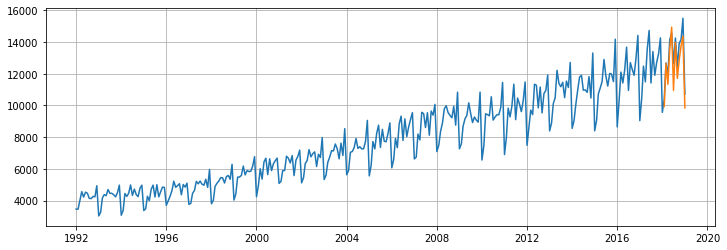

In [34]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x, true_preds)
plt.show()

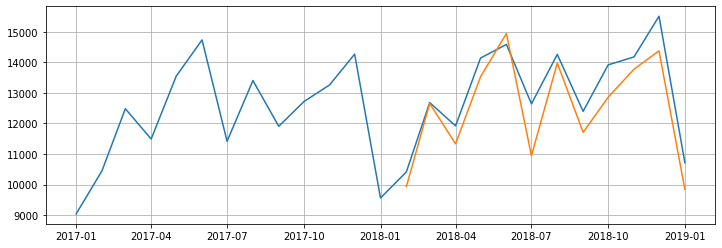

In [35]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x, true_preds)
plt.show()